In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-12-31 21:50:49.135090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Processing of the dataset**

In [135]:
%run dataset.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed with RDP.
Data saved as 'processed_data_rdp.csv'.


In [131]:
data = pd.read_csv('data/processed_data_rdp.csv', index_col=0)
data.head()

,Close,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,,
2005-02-01,1189.410034,9.251176,1.797314,-0.549336,-0.070571,-1.054000,1.480793
2005-02-02,1193.189941,11.402198,1.628523,0.722583,0.862218,0.432633,0.686745
2005-02-03,1189.890015,7.089487,1.306029,1.231909,0.184395,0.519542,0.642527
2005-02-04,1203.030029,17.700814,2.703699,3.010612,2.172498,1.274530,0.414279
2005-02-07,1201.719971,14.341911,1.731183,3.262726,1.452061,1.309236,0.390989


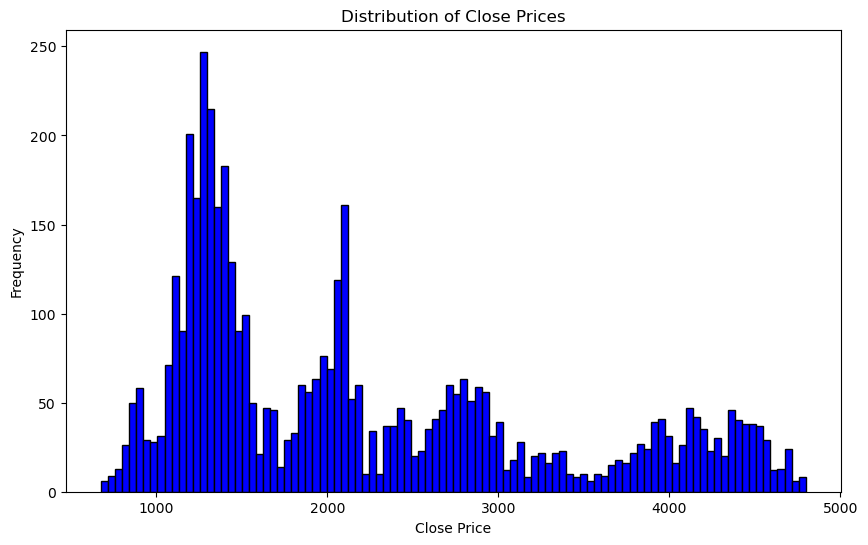

In [132]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

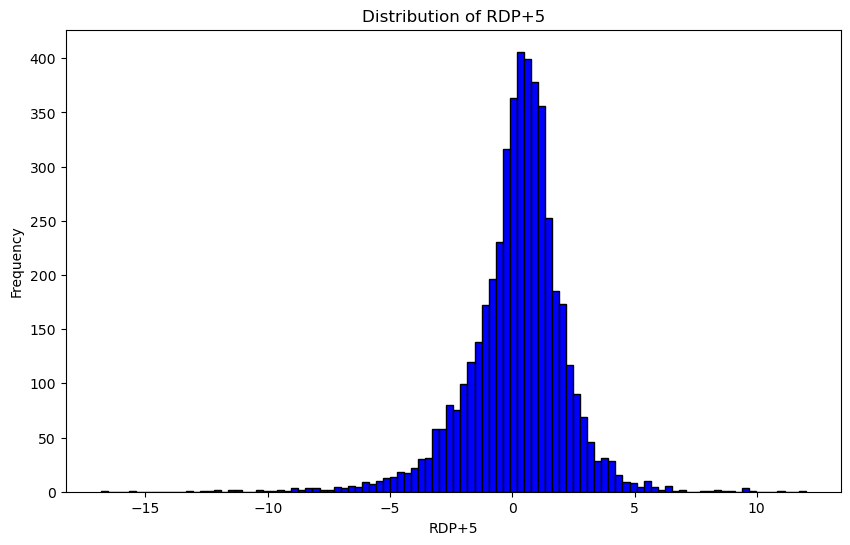

In [133]:
plt.figure(figsize=(10, 6))
plt.hist(data['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

### **Outliers**

In [107]:
def handle_outliers(dataframe, columns):
    """
    Replace outliers in specified columns with the closest marginal value.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to process.
    - columns (list): List of column names to apply outlier handling.
    
    Returns:
    - pd.DataFrame: DataFrame with outliers replaced.
    """
    for col in columns:
        mean = dataframe[col].mean()
        std_dev = dataframe[col].std()
        upper_limit = mean + 2 * std_dev
        lower_limit = mean - 2 * std_dev
        
        dataframe[col] = np.where(dataframe[col] > upper_limit, upper_limit, dataframe[col])
        dataframe[col] = np.where(dataframe[col] < lower_limit, lower_limit, dataframe[col])
    
    return dataframe

def scale_columns(dataframe, columns):
    """
    Scale the specified columns of a DataFrame to the range [-0.9, 0.9].

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names to scale.

    Returns:
    - pd.DataFrame: DataFrame with scaled columns.
    """
    scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
    dataframe[columns] = scaler.fit_transform(dataframe[columns])
    return dataframe

In [108]:
data_scaled = handle_outliers(data, columns=['RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = scale_columns(data_scaled, columns=['EMA15','RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = data_scaled.drop(columns=['Close'])
print(data_scaled.shape)
data_scaled.head()

(4756, 6)


,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,
2005-02-01,0.427594,0.298879,-0.122540,-0.065974,-0.171376,0.288841
2005-02-02,0.433592,0.267746,0.051282,0.038701,-0.024821,0.114253
2005-02-03,0.421567,0.208264,0.120888,-0.037362,-0.016253,0.104530
2005-02-04,0.451154,0.466056,0.363968,0.185738,0.058175,0.054345
2005-02-07,0.441788,0.286682,0.398423,0.104892,0.061596,0.049224


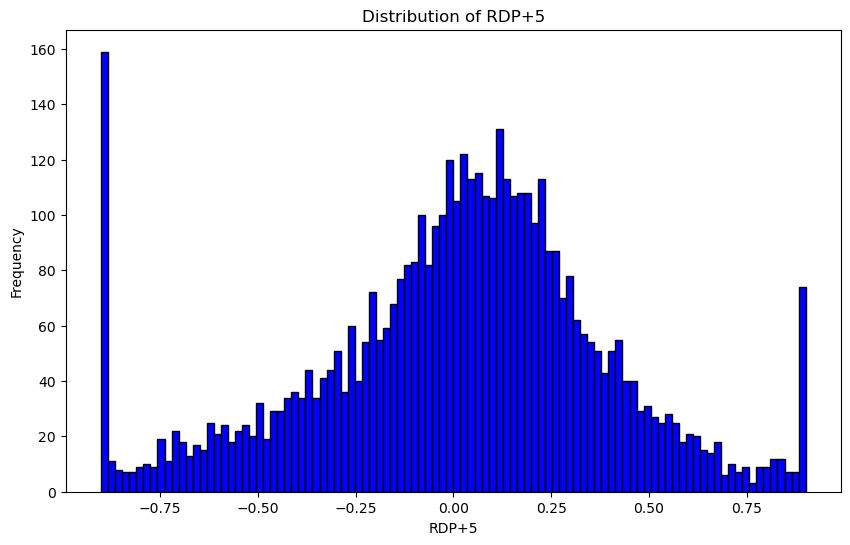

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(data_scaled['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

## Splitting the data into Training-Validation-Testing

In [110]:
def split_data(dataframe, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data into training, validation, and testing sets.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame to split.
    - train_ratio (float): Proportion of data for training (default: 0.7).
    - val_ratio (float): Proportion of data for validation (default: 0.15).

    Returns:
    - tuple: (train_data, val_data, test_data)
    """
    train_end = int(len(dataframe) * train_ratio)
    val_end = train_end + int(len(dataframe) * val_ratio)

    train_data = dataframe[:train_end]
    val_data = dataframe[train_end:val_end]
    test_data = dataframe[val_end:]

    return train_data, val_data, test_data

In [111]:
train_data, val_data, test_data = split_data(data_scaled)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Testing data: {test_data.shape}')

Training data: (3329, 6)
Validation data: (713, 6)
Testing data: (714, 6)


In [208]:
# SVM Regression Training and Evaluation
def train_and_evaluate_svm(train_data, val_data, test_data, features, target):
    """
    Train and evaluate an SVM regression model on the given data.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.

    Returns:
    - dict: A dictionary containing the model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features]
    y_train = train_data[target]

    X_val = val_data[features]
    y_val = val_data[target]

    X_test = test_data[features]
    y_test = test_data[target]

    # Train the SVR model
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)

    # Validate the model
    val_predictions = svr.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_nmse = val_mse / np.var(y_val)
    val_r2 = r2_score(y_val, val_predictions)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation NMSE: {val_nmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Test the model
    test_predictions = svr.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)
    test_r2 = r2_score(y_test, test_predictions)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test NMSE: {test_nmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Return results
    return {
        "model": svr,
        "val_predictions": val_predictions,
        "test_predictions": test_predictions,
        "y_test": y_test,
        "validation_metrics": {"mse": val_mse, "r2": val_r2, "nmse": val_nmse},
        "test_metrics": {"mse": test_mse, "r2": test_r2, "nmse": test_nmse},
    }

# Plot Predictions vs Actual Values
def plot_predictions(y_test, test_predictions, name_model,start_idx=0, end_idx=100):
    """
    Plot predictions vs actual values for a specified range.

    Parameters:
    - y_test (pd.Series): Actual target values from the test set.
    - test_predictions (np.ndarray): Predicted target values from the test set.
    - start_idx (int): Starting index for the range to plot.
    - end_idx (int): Ending index for the range to plot.
    """
    index = np.arange(abs(start_idx - end_idx))
    plt.figure(figsize=(10, 6))
    plt.plot(index, y_test.values[start_idx:end_idx], label='Actual Values', color='blue')
    plt.plot(index, test_predictions[start_idx:end_idx], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{name_model}: Predicted vs Actual')
    plt.xlabel('Index')
    plt.ylabel('RDP+5')
    plt.legend()
    plt.show()

Validation MSE: 0.1588
Validation NMSE: 0.9922
Validation R²: 0.0078
Test MSE: 0.1820
Test NMSE: 1.0480
Test R²: -0.0480


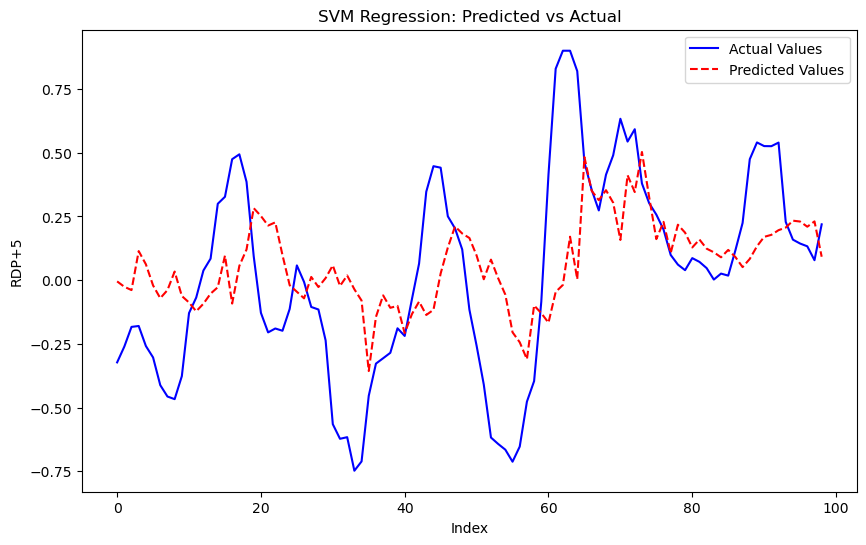

In [209]:
features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']
target = 'RDP+5'
svr_results = train_and_evaluate_svm(train_data, val_data, test_data, features, target)
plot_predictions(svr_results['y_test'], svr_results['test_predictions'],name_model = "SVM Regression", start_idx=-100, end_idx=-1)

### **Optimisation of the Hyper-parameters**

In [117]:
from sklearn.model_selection import GridSearchCV

def optimize_svm(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVM hyperparameters using GridSearchCV.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary specifying hyperparameter ranges for GridSearchCV.

    Returns:
    - dict: Best hyperparameters and the optimized model.
    """
    # Combine training and validation sets for optimization
    combined_data = pd.concat([train_data, val_data])
    X_combined = combined_data[features]
    y_combined = combined_data[target]

    # Initialize the SVR model
    svr = SVR(kernel='rbf')

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    # Perform the grid search
    grid_search.fit(X_combined, y_combined)

    # Extract the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best hyperparameters: {best_params}")

    # Train the final model using the best hyperparameters
    best_model = grid_search.best_estimator_

    return {
        "best_model": best_model,
        "best_params": best_params,
        "grid_search": grid_search
    }

In [124]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.1, 1, 10],
    "epsilon": [0.001, 0.01, 0.1],
    "gamma": [0.001 ,0.01, 0.1, 1]
}
# Optimize hyperparameters
optimization_results = optimize_svm(train_data, val_data, features, target, param_grid)

# Evaluate the best model on the test set
best_model = optimization_results["best_model"]
X_test = test_data[features]
y_test = test_data[target]
# Test the model
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test NMSE: {test_nmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   1.0s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   0.9s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   1.0s
[CV] END ....................C=0.001, epsilon=0.001, gamma=1; total time=   1.0s
[CV] END ....................C=0.001, epsilon=0.001, gamma=1; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.01

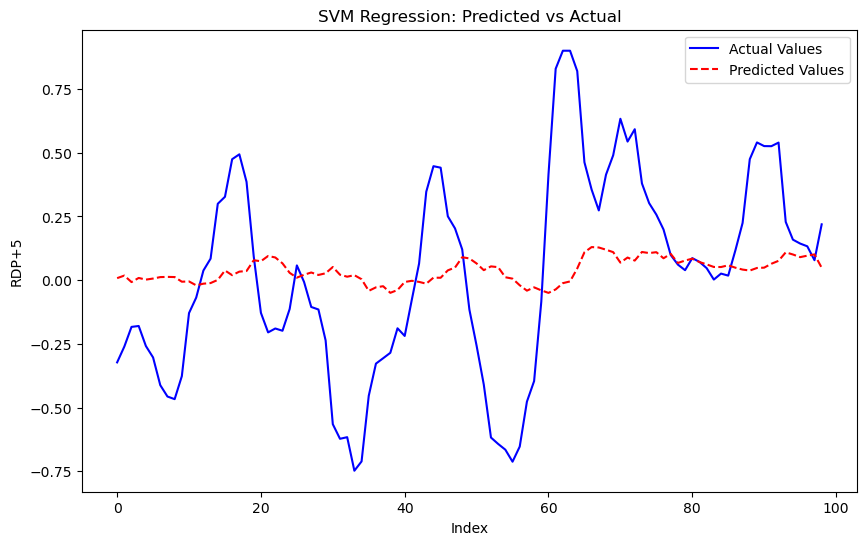

In [125]:
# Plot predictions for a specific range (e.g., last 100 data points)
plot_predictions(y_test, test_predictions, start_idx=-100, end_idx=-1)

## **Financial Time series (ARIMA/ARIMAX)**

In [181]:
from itertools import product
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

In [197]:
def run_arima(train_data, test_data, target, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMA model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - target (str): Name of the target column.
    - order (tuple): ARIMA model order (p, d, q).

    Returns:
    - dict: ARIMA model, predictions, and evaluation metrics.
    """
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data))

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)

    print(f"ARIMA ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMA ({order}) Test R²: {r2:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2
    }

# ARIMAX Model
def run_arimax(train_data, test_data, exog_train, exog_test, target, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMAX model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - exog_test (pd.DataFrame): Exogenous variables for testing.
    - target (str): Name of the target column.
    - order (tuple): ARIMAX model order (p, d, q).

    Returns:
    - dict: ARIMAX model, predictions, and evaluation metrics.
    """
    # Fit ARIMAX model
    model = SARIMAX(train_data, exog=exog_train, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data), exog=exog_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)
    nmse = mse / np.var(test_data)

    print(f"ARIMAX ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMAX ({order}) Test R²: {r2:.4f}")
    print(f"ARIMAX ({order}) Test NMSE: {nmse:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2,
        "nmse": nmse
    }

In [198]:
# Define target and exogenous features
target = 'RDP+5'
exogenous_features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']

# Combine train and validation sets for ARIMA/ARIMAX
combined_train = pd.concat([train_data, val_data])

# Split data
y_train = combined_train[target]
y_test = test_data[target]

X_train = combined_train[exogenous_features]
X_test = test_data[exogenous_features]

ARIMA ((1, 1, 1)) Test MSE: 0.1736
ARIMA ((1, 1, 1)) Test R²: 0.0001


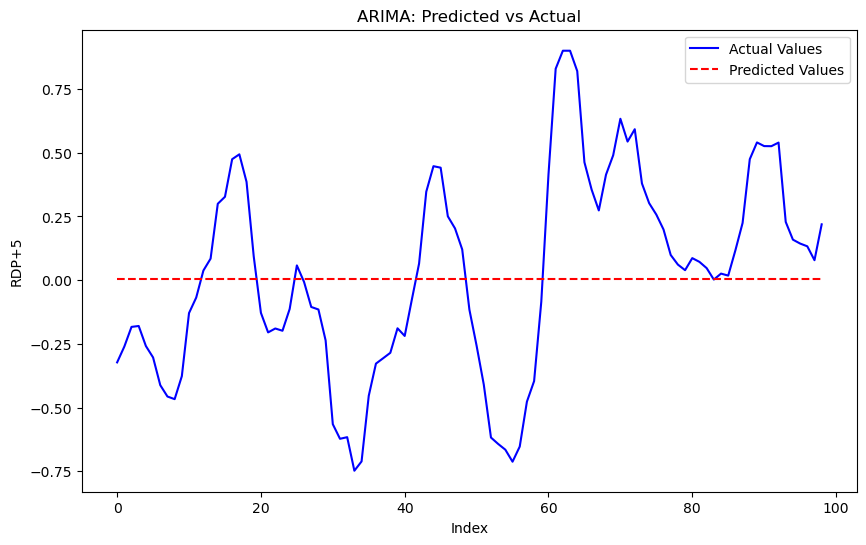

In [199]:
# Run ARIMA
arima_results = run_arima(y_train, y_test, target, order=(1, 1, 1))
arima_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arima_results['predictions'], name_model = "ARIMA", start_idx=-100, end_idx=-1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.57985D-01    |proj g|=  1.97758D-01

At iterate    5    f= -5.66898D-01    |proj g|=  1.20588D-02

At iterate   10    f= -5.67020D-01    |proj g|=  5.50801D-03

At iterate   15    f= -5.67034D-01    |proj g|=  2.64156D-04

At iterate   20    f= -5.67034D-01    |proj g|=  1.29377D-03

At iterate   25    f= -5.67035D-01    |proj g|=  2.98396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     32      1     0     0   

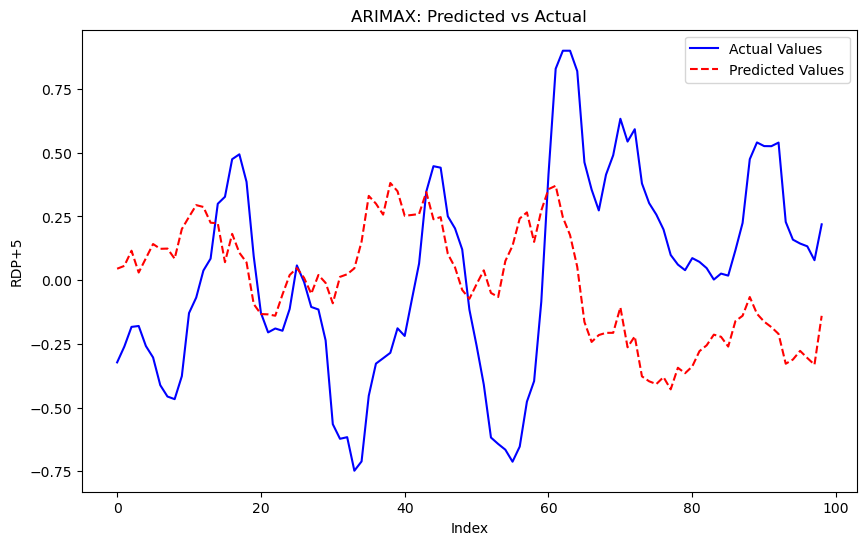

In [200]:
# Run ARIMAX
arimax_results = run_arimax(y_train, y_test, X_train, X_test, target, order=(1, 1, 1))
arimax_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arimax_results['predictions'], name_model = "ARIMAX", start_idx=-100, end_idx=-1)

In [211]:
# ARIMAX Optimization
def optimize_arimax(train_data, test_data, exog_train, exog_test, target, p_values, d_values, q_values):
    """
    Optimize the ARIMAX model by searching for the best combination of p, d, and q values.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - exog_test (pd.DataFrame): Exogenous variables for testing.
    - target (str): Name of the target column.
    - p_values (list): List of p values to try.
    - d_values (list): List of d values to try.
    - q_values (list): List of q values to try.

    Returns:
    - dict: Best ARIMAX model, its parameters, and evaluation metrics.
    """
    best_mse = float('inf')
    best_order = None
    best_model = None

    for p, d, q in product(p_values, d_values, q_values):
        try:
            print(f"Evaluating ARIMAX({p},{d},{q})...")
            model = SARIMAX(train_data, exog=exog_train, order=(p, d, q))
            model_fitted = model.fit(disp=False)
            predictions = model_fitted.forecast(steps=len(test_data), exog=exog_test)
            mse = mean_squared_error(test_data, predictions)

            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
                best_model = model_fitted

        except Exception as e:
            print(f"ARIMAX({p},{d},{q}) failed: {e}")

    print(f"Best ARIMAX Order: {best_order} with MSE: {best_mse:.4f}")
    
    y_pred = best_model.forecast(steps=len(test_data), exog=exog_test)
    r2 = r2_score(test_data, y_pred)
    nmse = best_mse / np.var(test_data)
    
    print(f"Best ARIMAX Test R²: {r2:.4f}")
    print(f"Best ARIMAX Test NMSE: {nmse:.4f}")
    
    return {
        "best_model": best_model,
        "best_order": best_order,
        "mse": best_mse,
        "r2": r2,
        "nmse": nmse
    }

In [212]:
# Optimize ARIMAX
p_values = [1, 2, 3]
d_values = [0, 1]
q_values = [1, 2, 3]

amimax_optimized_results = optimize_arimax(y_train, y_test, X_train, X_test, target, p_values, d_values, q_values)

Evaluating ARIMAX(1,0,1)...
Evaluating ARIMAX(1,0,2)...
Evaluating ARIMAX(1,0,3)...
Evaluating ARIMAX(1,1,1)...
Evaluating ARIMAX(1,1,2)...
Evaluating ARIMAX(1,1,3)...
Evaluating ARIMAX(2,0,1)...
Evaluating ARIMAX(2,0,2)...
Evaluating ARIMAX(2,0,3)...
Evaluating ARIMAX(2,1,1)...
Evaluating ARIMAX(2,1,2)...
Evaluating ARIMAX(2,1,3)...
Evaluating ARIMAX(3,0,1)...
Evaluating ARIMAX(3,0,2)...
Evaluating ARIMAX(3,0,3)...
Evaluating ARIMAX(3,1,1)...
Evaluating ARIMAX(3,1,2)...
Evaluating ARIMAX(3,1,3)...
Best ARIMAX Order: (2, 0, 3) with MSE: 0.2534
Best ARIMAX Test R²: -0.4591
Best ARIMAX Test NMSE: 1.4591


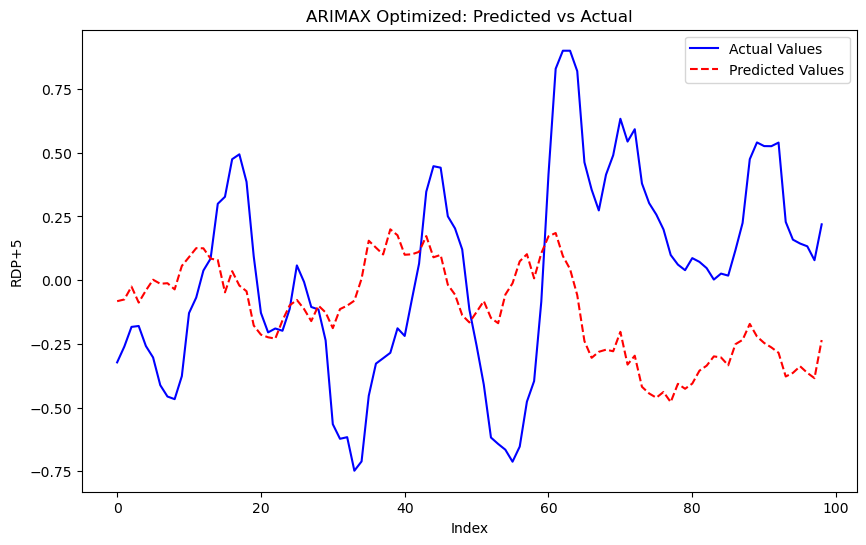

In [214]:
plot_predictions(y_test, amimax_optimized_results['best_model'].forecast(steps=len(test_data), exog=X_test), name_model = "ARIMAX Optimized", start_idx=-100, end_idx=-1)

## **Backpropagation (Neural Network)**

In [215]:
# Backpropagation Neural Network Model
def run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32):
    """
    Fit and evaluate a Backpropagation neural network model.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - epochs (int): Number of epochs for training.
    - batch_size (int): Batch size for training.

    Returns:
    - dict: Neural network model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features].values
    y_train = train_data[target].values

    X_val = val_data[features].values
    y_val = val_data[target].values

    X_test = test_data[features].values
    y_test = test_data[target].values

    # Normalize the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Build the model
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Evaluate on the test set
    test_predictions = model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)

    print(f"Backpropagation Test MSE: {test_mse:.4f}")
    print(f"Backpropagation Test R²: {test_r2:.4f}")
    print(f"Backpropagation Test NMSE: {test_nmse:.4f}")

    return {
        "model": model,
        "history": history,
        "predictions": test_predictions,
        "mse": test_mse,
        "r2": test_r2,
        "nmse": test_nmse
    }

In [216]:
# Run Backpropagation
backprop_results = run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32)

Epoch 1/50
105/105 - 1s - 11ms/step - loss: 0.1336 - mae: 0.2764 - val_loss: 0.1611 - val_mae: 0.3142
Epoch 2/50
105/105 - 0s - 2ms/step - loss: 0.1324 - mae: 0.2745 - val_loss: 0.1655 - val_mae: 0.3232
Epoch 3/50
105/105 - 0s - 2ms/step - loss: 0.1335 - mae: 0.2775 - val_loss: 0.1620 - val_mae: 0.3167
Epoch 4/50
105/105 - 0s - 2ms/step - loss: 0.1321 - mae: 0.2744 - val_loss: 0.1581 - val_mae: 0.3090
Epoch 5/50
105/105 - 0s - 2ms/step - loss: 0.1311 - mae: 0.2738 - val_loss: 0.1560 - val_mae: 0.3078
Epoch 6/50
105/105 - 0s - 2ms/step - loss: 0.1311 - mae: 0.2730 - val_loss: 0.1579 - val_mae: 0.3112
Epoch 7/50
105/105 - 0s - 2ms/step - loss: 0.1305 - mae: 0.2733 - val_loss: 0.1554 - val_mae: 0.3055
Epoch 8/50
105/105 - 0s - 2ms/step - loss: 0.1307 - mae: 0.2739 - val_loss: 0.1552 - val_mae: 0.3035
Epoch 9/50
105/105 - 0s - 2ms/step - loss: 0.1302 - mae: 0.2730 - val_loss: 0.1556 - val_mae: 0.3034
Epoch 10/50
105/105 - 0s - 2ms/step - loss: 0.1304 - mae: 0.2728 - val_loss: 0.1529 - val_

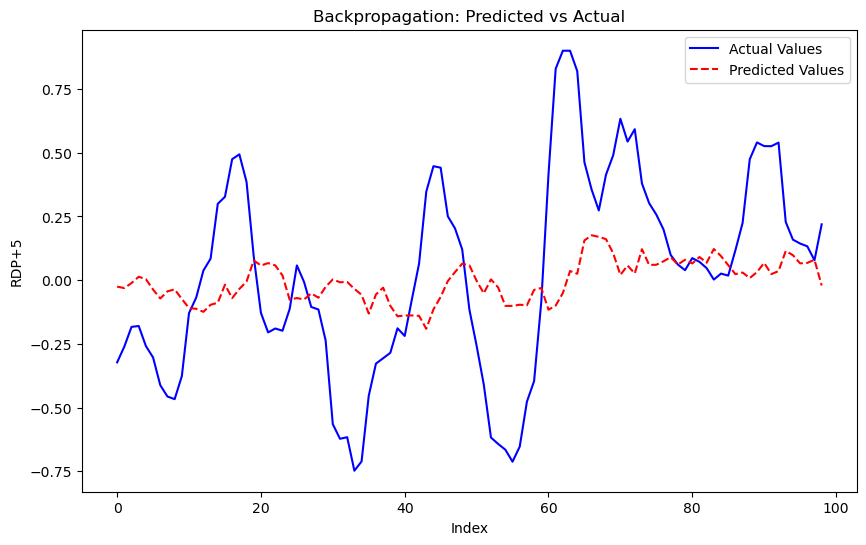

In [217]:
plot_predictions(y_test,backprop_results['predictions'], name_model = "Backpropagation", start_idx=-100, end_idx=-1)

## **Comparison of the models**

In [218]:
print("SVM Regression: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(svr_results['test_metrics']['mse'], svr_results['test_metrics']['r2'],svr_results['test_metrics']['nmse'] ))
print("ARIMAX: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(amimax_optimized_results['mse'], amimax_optimized_results['r2'], amimax_optimized_results['nmse']))
print("Backpropagation: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(backprop_results['mse'], backprop_results['r2'], backprop_results['nmse']))

SVM Regression: MSE = 0.1820, R² = -0.0480, NMSE = 1.0480
ARIMAX: MSE = 0.2534, R² = -0.4591, NMSE = 1.4591
Backpropagation: MSE = 0.1732, R² = 0.0027, NMSE = 0.9973
